# PHYS250 Final Project: In Search of Emergent Phenomena in Empirically Constructed Model of Shoaling Fish

### Motoya Kimura

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.markers as mmarkers
from matplotlib.markers import MarkerStyle
import matplotlib.animation as animation
import matplotlib.cm as cm
import copy

### Import Fish Svg 

In [37]:
fih_path, attributes = svg2paths('fish.svg')
fmarker = parse_path(attributes[0]['d'])
fmarker.vertices -= fmarker.vertices.mean(axis=0)
fmarker = fmarker.transformed(mpl.transforms.Affine2D().scale(1,-1))
# plt.plot(1,1,marker = fmarker, markersize = 100)

### Initialization function

In [38]:
def initialize(numfish, maxcoord, maxvelocity = 10):
    N = numfish #number of fish
    maxvelocity = maxvelocity #bodylength per seconds

    #init coordinations
    motcoords = [np.array([rng.uniform(-maxcoord,maxcoord),rng.uniform(-maxcoord,maxcoord)]) for i in np.arange(N)]

    # init orientations
    radmotangles = [np.array(rng.uniform(0, 2*np.pi)) for i in np.arange(N)]
    degmotangles = np.rad2deg(radmotangles)

    #initialize velocity magnitude array
    
    #add initial velocities 
    motvelmag = rng.normal(1,0.5,numfish)

    #create a velocity (direction & magnitude) array
    motvel = [np.array((motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i]))) for i in np.arange(N)]
    return motcoords, radmotangles, motvelmag, motvel


### Calculations for rule-setting

In [39]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(mycoord - i) for i in coordarray]
    distances[myindex] = np.nan
    return distances

#define crossproduct
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    nearestdist = dist[np.nanargmin(dist)]
    return neighbor_index, nearestdist, dist

def findangletoneighbor(radmyorientation, mycoord, neighborcoord):
    myvector = (np.cos(radmyorientation),np.sin(radmyorientation))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    #calculate the dot product and the cross product
    dotproduct = np.dot(myvector, vector_from_me_to_you) 
    crossproduct = cross2d(myvector, vector_from_me_to_you)
    return dotproduct, crossproduct

# #first find and index nearest neighbor
# testcoord = np.array([0,0])
# coords = [np.array([0,0]), np.array([-1,-1]), np.array([2,0]), np.array([0,3]), np.array([-4,3])]
# findnearestneighbor(0, testcoord, coords)


In [40]:
def finddistancetonearestwall(mycoord, maxcoord):
    
    xdistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[0]))
    ydistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[1]))

    if mycoord[0] < 0:
        xdistance = -1*xdistance
    else: xdistance = xdistance
    if mycoord[1] < 0:
        ydistance = -1*ydistance
    else: ydistance = ydistance
    return xdistance, ydistance

def findangletowall(radmyorientation, mycoord, maxcoord):
    myvector = np.array([np.cos(radmyorientation),np.sin(radmyorientation)])

    #nearest walls
    xwall, ywall = finddistancetonearestwall(mycoord, maxcoord)

    if xwall != 0:
        xwallvector = np.array([1,0]) if xwall < 0 else np.array([-1,0])
    else: xwallvector = np.array([0,0])
    if ywall != 0:
        ywallvector = np.array([0,1]) if ywall < 0 else np.array([0,-1])
    else: ywallvector = np.array([0,0])
    
    #calculate the dot product and the cross product
    xdotproduct = np.dot(myvector, xwallvector) 
    ydotproduct = np.dot(myvector, ywallvector) 
    xcrossproduct = cross2d(myvector,xwallvector)
    ycrossproduct = cross2d(myvector,ywallvector)
    return xdotproduct, ydotproduct, xcrossproduct, ycrossproduct

# coord = (-2,2)
# arena = 10

# finddistancetonearestwall(coord,arena/2)

In [41]:
# #test
# poolsize = 10
# N = 1
# motcoords, radmotangles, motvelmag, motvel = initialize(N,poolsize/2)

# xcoords, ycoords = zip(*motcoords)

# degmotangles = np.rad2deg(radmotangles)

# fig, ax = plt.subplots()
# # scaling follows s = 160000/x^2 where x is the width of the coordinate
# for i in np.arange(len(motcoords)):
#     rotfmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
#     ax.scatter(xcoords[i],ycoords[i], marker = rotfmarker, s = 160000/poolsize**2)

# ax.set_xlim(-poolsize/2,poolsize/2)
# ax.set_ylim(-poolsize/2,poolsize/2)
# ax.grid()
# plt.show()

# print(motcoords)
# print(degmotangles)

# for i in np.arange(N):
#     # print(findangletoneighbor(radmotangles[0], motcoords[0], motcoords[i]))
#     print(finddistancetonearestwall(motcoords[0], poolsize/2))
#     print(findangletowall(radmotangles[0],motcoords[0],poolsize/2))


### Equations for fish interaction 

- Radius of 2 body lengths = R 

- Speed: Acceleration response is stronger for neighbors directly in front and directly behind
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor?
    - Possible weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back

 Orientation: 
- Turn towards neighbor’s position outside radius R
- Turn away from neighbor if within radius R
- Include wall repulsion 

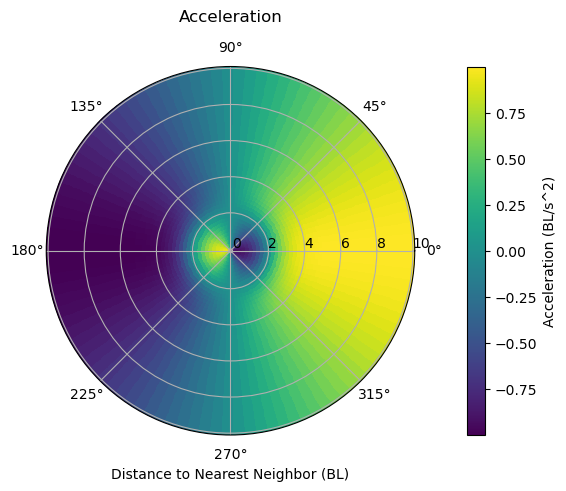

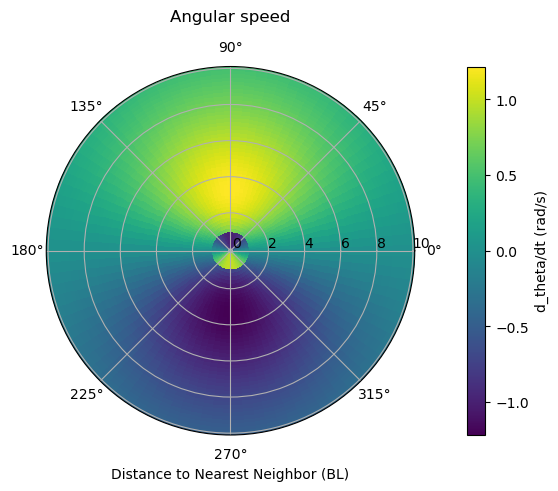

In [42]:
#plot the translational and angular acceleration functions:
r_values = np.linspace(0, 10, 50)  # Radial distances
theta_values = np.linspace(0, 2 * np.pi, 100) # Angles in radians
R, THETA = np.meshgrid(r_values, theta_values)

# Example 'z'data (e.g., a function of r and theta)
Zfar = np.cos(THETA) * np.tanh(R-2)
# Zclose = -np.cos(THETA)

# Zclose_masked = np.where(R <= 2, Zclose, np.nan)

# #consistent Acceleration values for heatmap
# Zmin = np.nanmin([Zfar.min(), Zclose.min()])
# Zmax = np.nanmax([Zfar.max(), Zclose.max()])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, Zfar, cmap='viridis') 
# # Choose a colormap
# heatmapclose = ax.pcolormesh(THETA, R, Zclose_masked, cmap='viridis',vmin=Zmin, vmax=Zmax) # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='Acceleration (BL/s^2)')
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")
ax.set_title("Acceleration", y = 1.1)

plt.savefig("acceleration.png")
plt.show()

#Angular acceleration heatmap * np.tanh(R/5)
AAfar = 1*np.sin(THETA)*R*np.exp(-(R/3))**(np.e/3)
AAclose = -1*np.sin(THETA)

# AAclose_masked = np.where(R <= 2, AAclose, np.nan)
AAclose_masked = np.where(R <= 1, AAclose, np.nan)

#consistent angular frequency values for heatmap
AAmin = np.nanmin([AAfar.min(), AAclose.min()])
AAmax = np.nanmax([AAfar.max(), AAclose.max()])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, AAfar, cmap='viridis',vmin=AAmin, vmax=AAmax) # Choose a colormap
heatmapclose = ax.pcolormesh(THETA, R, AAclose_masked, cmap='viridis',vmin=AAmin, vmax=AAmax) # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='d_theta/dt (rad/s)')
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")
ax.set_title("Angular speed", y = 1.1)

plt.savefig("Turning.png")
plt.show()

### Fish Update Function

In [43]:
#run this for all fish in one timestep

def updatefish(positions,radorientations,speeds,velocity, arenarange = 100, time = 0, timestep = 0.05, maxa = 1.0, maxdw = 1.0, erroracc = 0.00, errordw = 0.00, maxspd = 10, Wbias = 1, Abias = 1, forwardbias = True, lw = 3):
    copypositions = positions.copy()
    time += timestep
    t = timestep
    N = len(positions)
    maxspeed = maxspd
    maxcoord = arenarange/2

    #keep track of nearest neighbor distance for data later
    neighdistarray = []

    for i in np.arange(N):
        #first find the nearest neighbor
        neighindex, neighdist, dist = findnearestneighbor(i, copypositions[i], copypositions)

        neighdistarray.append(neighdist)

        #find its dotproduct
        dotproduct, crossproduct = findangletoneighbor(radorientations[i],copypositions[i],copypositions[neighindex]) #simply cos(theta) and sin(theta)

        #error in acceleration
        Aerror = rng.uniform(-erroracc,erroracc)
        Dwerror = rng.uniform(-errordw,errordw)

        #bias in translational acceleration: if bias = 1 then they are equal
        lessmaxa = Abias*maxa
        if forwardbias == True: #more weight towards forward neighbors
            Aweight = lessmaxa if np.sign(dotproduct) < 0 else maxa
        else: #more weight towards neighbors behind
            Aweight = maxa if np.sign(dotproduct) < 0 else lessmaxa
        
        #calculate the accelerations based on the dotproduct and the distance to the neighbor
        motaccpositive = Aweight*dotproduct*np.tanh(neighdist - 2) + Aerror

        #Speed rule 1, attractve over R (2 body lengths) and repulsive under R. tanh(R-2) makes sure it is continuous 
        #and changes sign at R = 2
        if np.abs(speeds[i] + motaccpositive*t) <= maxspeed:
            speeds[i] = max(0, speeds[i] + motaccpositive*t)
        else: speeds[i] = min(maxspeed, speeds[i] + motaccpositive*t)
        
        #bias between forward and backward alignment
        lessmaxdw = Wbias*maxdw
        
        #1*np.sin(THETA)*R*1*np.sin(THETA)*R*np.exp(-(R/5)**2)/2
        if forwardbias == True: #more weight towards forward neighbors
            dwfar = maxdw*crossproduct*neighdist*np.exp(-(neighdist/lw))*(np.e/lw) + Dwerror if np.sign(dotproduct) > 0 else lessmaxdw*crossproduct*neighdist*np.exp(-(neighdist/lw))*(np.e/lw) + Dwerror
        else: #more weight towards neighbors behind
            dwfar = lessmaxdw*crossproduct*neighdist*np.exp(-(neighdist/3))*(np.e/lw) + Dwerror if np.sign(dotproduct) > 0 else maxdw*crossproduct*neighdist*np.exp(-(neighdist/lw))*(np.e/lw) + Dwerror

        dwnear = maxdw*crossproduct + Dwerror 

        #orientation rule 1, turn towards nearest neighbor
        if neighdist >= 1: #radpersecond
            radorientations[i] = radorientations[i] + dwfar*t
        elif neighdist < 1: #radpersecond
            radorientations[i] = radorientations[i] -  dwnear*t

        #add repulsive force towards wall
        xwalldist, ywalldist = finddistancetonearestwall(copypositions[i], maxcoord)
        xwalldot, ywalldot, xwallcross, ywallcross = findangletowall(radorientations[i], copypositions[i], maxcoord)
        
        #make sure direction is correct
        xsign = np.sign(xwallcross)
        ysign = np.sign(ywallcross)
        
        #angular frequency for wall 
        dwwallx = maxdw*np.abs(xwalldot)*xsign + Dwerror
        dwwally = maxdw*np.abs(ywalldot)*ysign + Dwerror

        if np.abs(xwalldist) < 2 and xwalldot < 0:
            radorientations[i] += dwwallx * t

        if np.abs(ywalldist) < 2 and ywalldot < 0:   
            radorientations[i] += dwwally * t

        if xwalldot < 0 and ywalldot < 0 and np.sqrt(xwalldist**2+ywalldist**2) < 4:
            radorientations[i] += rng.choice([-3*np.pi/4,3*np.pi/4])

        #wall effect on acceleration. decelerate if dot product is negative, accelerate if positive
        awallx = maxa*xwalldot + Dwerror
        awally = maxa*ywalldot + Dwerror

        if np.abs(xwalldist) < 2:
            speeds[i] = max(0,speeds[i] + awallx * t)

        if np.abs(ywalldist) < 2:   
            speeds[i] = max(0,speeds[i] + awally * t)
        
        #update velocity
        velocity[i] = (speeds[i]*np.cos(radorientations[i]),speeds[i]*np.sin(radorientations[i]))

        #check position so that it is in bounds
        checknewposition = positions[i] + np.array(velocity[i])*t

        #if out of bounds, move fish to 1 BL from border and decelerate to 0, update velocity
        if np.abs(checknewposition[0]) > maxcoord or np.abs(checknewposition[1]) > maxcoord:
            if checknewposition[0] > maxcoord:
                positions[i][0] = maxcoord - 1
            if checknewposition[0] < -maxcoord:
                positions[i][0] = -maxcoord + 1
            if checknewposition[1] > maxcoord:
                positions[i][1] = maxcoord - 1
            if checknewposition[1] < -maxcoord:
                positions[i][1] = -maxcoord + 1
        
            speeds[i] = 0
            velocity[i] = (0,0)
        else: positions[i] = positions[i] + np.array(velocity[i])*t # update position according to x = x+vt for all fish

    neighdistmean = np.mean(neighdistarray)
        
    return positions, radorientations, speeds, velocity, time, neighdistmean

# Plot and analysis

In [44]:
#plotting function

def plot(coords, radorientations, viewrange = (-50,50), title = '', fishmarker = fmarker, save = False):
    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    colors = cm.rainbow(np.linspace(0, 1, N))
    
    fig, ax = plt.subplots()
    # scaling follows s = 160000/x^2 where x is the width of the coordinate

    for i in np.arange(N):
        rotmarker = fishmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 160000/figurelength**2, color = colors[i])

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()

    if save == True:
        plt.savefig("SimFigure.png")
        
    plt.show()


### Example plot

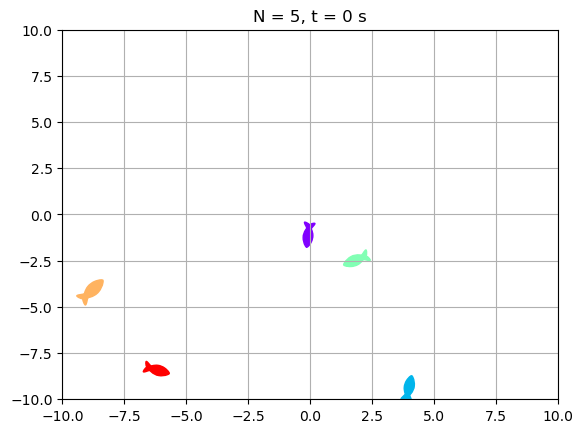

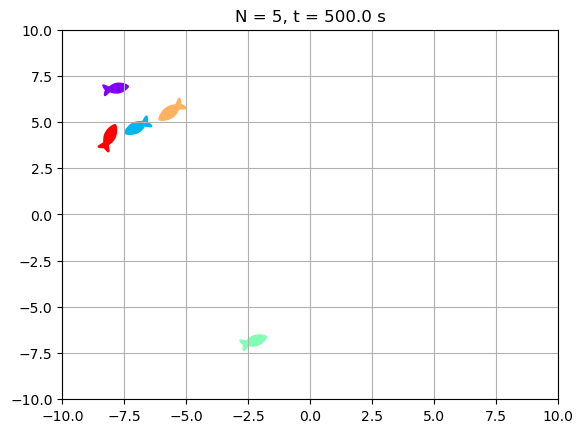

In [45]:
numiterations = 10000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 5
inittime = 0
positionarray = []
speedarray = []
meandistarray = []

#keep track of seed just for consistent plotting
# rng.seed(11)

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f'N = {numfish}, t = 0 s')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime, meanneighdist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, Wbias = 0.5)
    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))
    meandistarray.append(copy.deepcopy(meanneighdist))


plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f'N = {numfish}, t = {inittime:.1f} s', save = True)

In [46]:
#calculate the mean distance:
np.mean(meandistarray)

np.float64(2.5716284270651393)

### Trajectory Plot

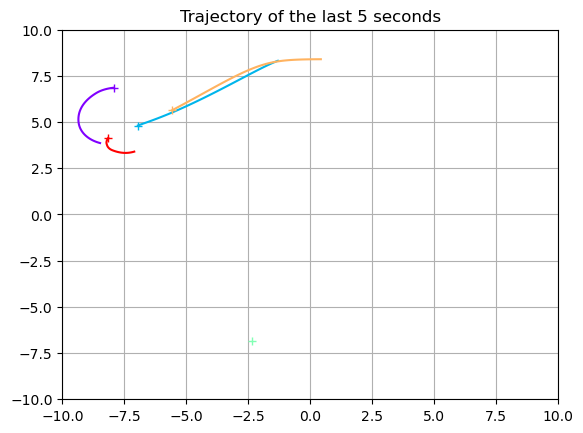

In [47]:
#trajectory plot
fig, ax = plt.subplots()

plotmaxcoord = poolrange/2
trajlength = 100
trajlengthtosec = 100*0.05

colors = cm.rainbow(np.linspace(0, 1, numfish))

for n in np.arange(numfish):
    coordinates = []
    for i in np.arange(numiterations):
        coordinates.append(positionarray[i][n])
    fishcoordsx, fishcoordsy = zip(*coordinates)

    recent_x = fishcoordsx[-trajlength:]
    recent_y = fishcoordsy[-trajlength:] 

    ax.plot(recent_x, recent_y, color=colors[n])
    ax.plot(recent_x[-1], recent_y[-1], marker='+', color=colors[n])

ax.set_xlim(-plotmaxcoord,plotmaxcoord)
ax.set_ylim(-plotmaxcoord,plotmaxcoord)
ax.set_title('Trajectory of the last 5 seconds')

ax.grid()
# plt.savefig('traj.png')
plt.show()


Final velocity plot function

In [48]:
#final velocity plot function
def plotvel(coords, radorientations, speeds, viewrange = (-50,50), title = ''):
    markerstyle = MarkerStyle(marker= '_')

    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    
    fig, ax = plt.subplots()

    # scaling of the length is proportional to the velocity
    for i in np.arange(N):
        rotmarker = markerstyle.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        scale = speeds[i]
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 500*scale)

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()

    plt.show()

### Final Velocity Plot

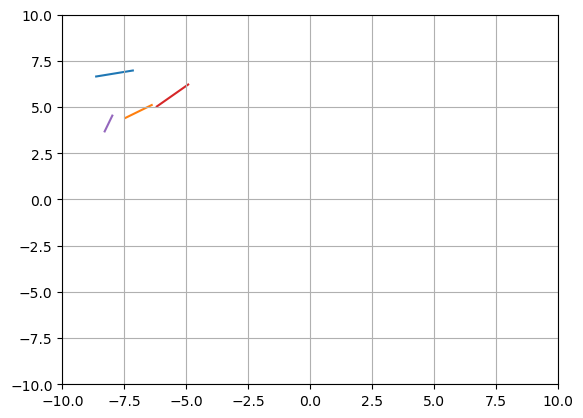

In [49]:
#final velocity plot:
plotvel(pos, motorientations, motspeeds, viewrange = (-plotmaxcoord,plotmaxcoord))

average speed = 1.078033606659689


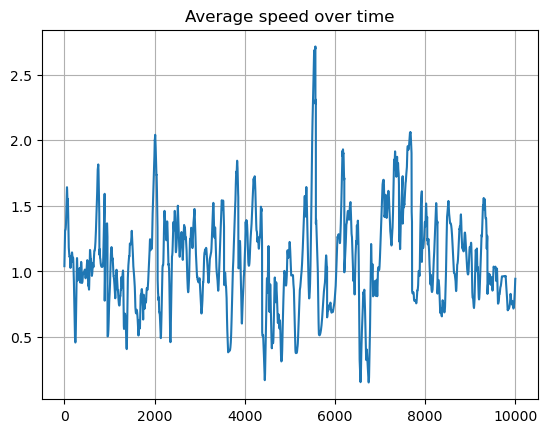

In [50]:
#plot changes in speed:
speedavg = [np.mean(array) for array in speedarray]
plt.plot(np.arange(len(speedavg)),speedavg)
plt.title('Average speed over time')
meanspeedaverage = np.mean(speedavg)
print(f'average speed = {meanspeedaverage}')
plt.grid()

speedsforeachfish = []
for i in np.arange(numfish):
    speedonefish = [array[i] for array in speedarray]
    speedsforeachfish.append(speedonefish)

# Analysis


Functions for analysis: Polarization, Milling, Cohesion

In [51]:
#center of mass

def findCM(positionarray):
    N = len(positionarray)
    sum = np.sum(positionarray, axis = 0)
    centerofmass = sum/N
    return centerofmass

def findVCM(velocityarray):
    N = len(velocityarray)
    sum = np.sum(velocityarray, axis = 0)
    Vcm = sum/N
    return Vcm

def findP(radorientations):
    N = len(radorientations)
    #normalize the velocities => basically [cos(angle),sin(angle)]
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    #add them up
    NormVsum = np.sum(normvel, axis = 0)
    #take the magnitude of the sum
    mag = np.linalg.norm(NormVsum)
    #divide by N
    P = mag/N
    return P

#also known as dispersion
def findCohesion(positionarray):
    N = len(positionarray)
    cm = findCM(positionarray)
    distfromcm = [np.linalg.norm(coords-cm) for coords in positionarray] 
    distsquared = np.square(distfromcm)
    distsqsum = np.sum(distsquared, axis = 0)
    cohesion = np.sqrt(distsqsum/N)
    return cohesion

def findMilling(positionarray, radorientations):
    N = len(positionarray)
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    normpos = [position/np.linalg.norm(position) for position in positionarray]
    crossp = [cross2d(normpos[i], normvel[i]) for i in np.arange(N)]
    sumofcrossp = np.sum(crossp, axis = 0)
    milling = np.abs(sumofcrossp)/N
    return milling



Perform the analysis for numfish = 5, 10, 30

We first need to check if they result in an equilibriated state
let's start with n = 5

- Keep numiterations = 1000
- poolrange = 20
- initcoordmax = 10 

### N = 5

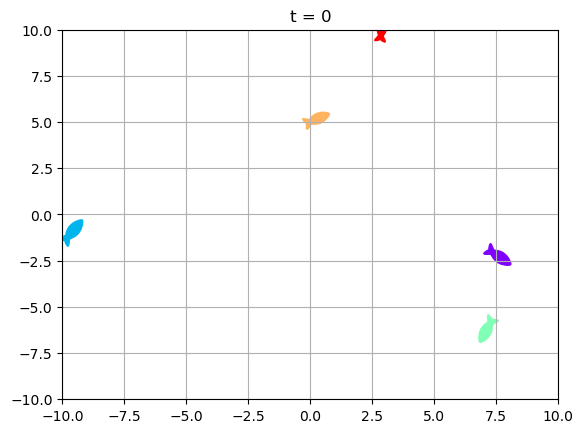

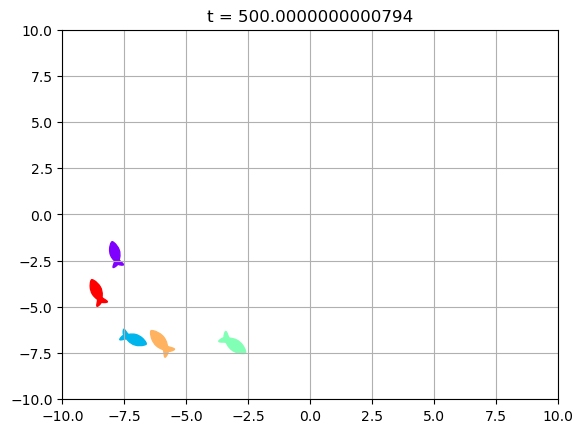

In [52]:
# N = 5

numiterations = 10000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 5
inittime = 0

#data arrays
positionarray = []
speedarray = []
cmpositionarray = []
cmvelocityarray = []
Parray = []
Carray = []
Marray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
#initial plot
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)

    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

    cmposition = findCM(pos)
    cmpositionarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    cmvelocityarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    Parray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    Carray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    Marray.append(copy.deepcopy(Milling))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')

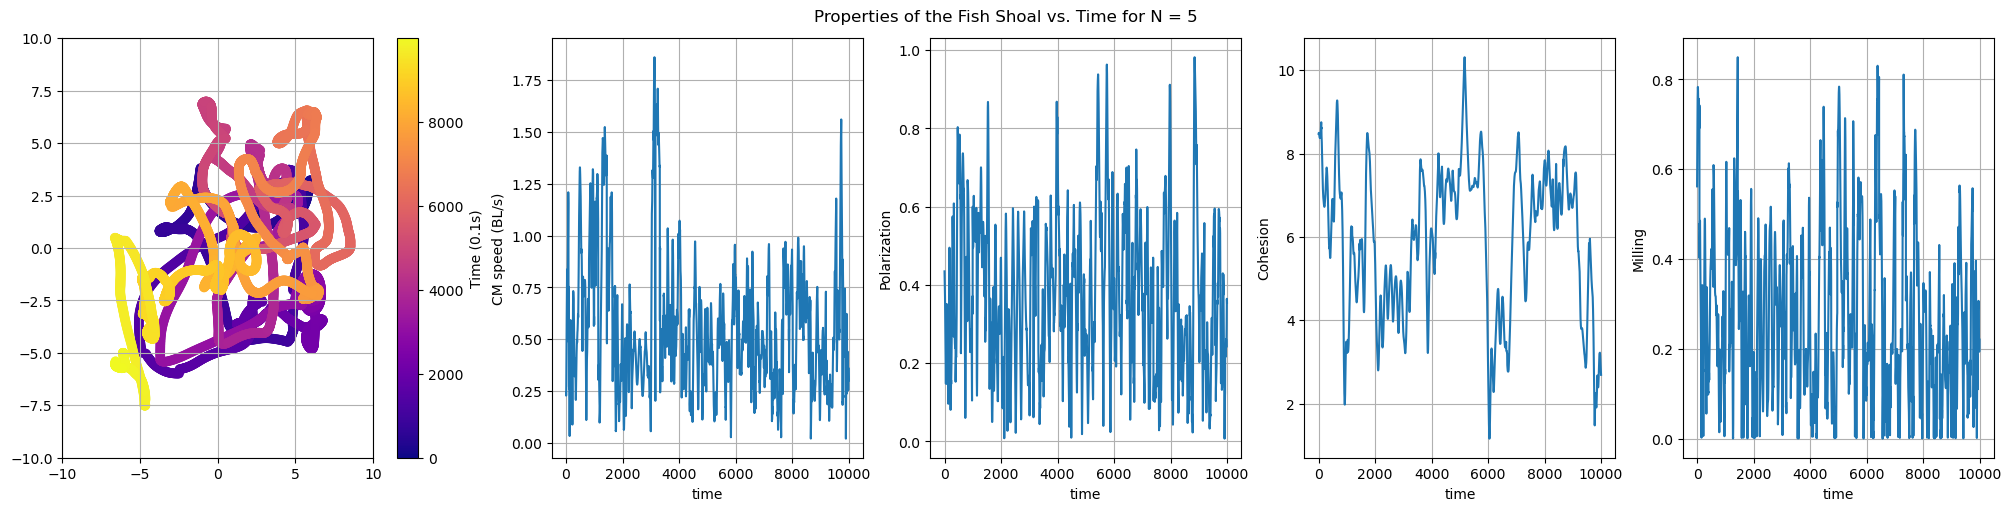

In [53]:
# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for N = 5')

time = np.arange(numiterations)

#plot center of mass over time
cmxcoords, cmycoords = zip(*cmpositionarray)
c_values = np.arange(len(cmxcoords))

sc = axs[0].scatter(cmxcoords, cmycoords, c = c_values, cmap = 'plasma')
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label("Time (0.1s)")

#plot center of mass speed over time
cmspeed = [np.linalg.norm(velocity) for velocity in cmvelocityarray]

axs[1].plot(time, cmspeed)
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('CM speed (BL/s)')


# plot polarization over time Parray = []
axs[2].plot(time, Parray)
axs[2].grid()
axs[2].set_xlabel('time')
axs[2].set_ylabel('Polarization')


# Carray = []
axs[3].plot(time, Carray)
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Cohesion')

# Marray = []
axs[4].plot(time, Marray)
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Milling')
plt.show()

Conclusion, we don't see equilibrium over time

In [ ]:
#Now run it many times and find the average properties at t = 1000
numsim = 50

totalcmarray = []
totalcmVarray = []
totalParray = []
totalCarray = []
totalMarray = []

for i in np.arange(numsim):
    numiterations = 1000
    poolrange = 20 #poolrange/2 is the length of each side
    initcoordmax = 10 #essentially initial density
    numfish = 5
    inittime = 0

    pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
    
    #run the simulation numiteration times
    for i in np.arange(numiterations):
        pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, )

    #calculate the final properties
    cmposition = findCM(pos)
    totalcmarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    totalcmVarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    totalParray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    totalCarray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    totalMarray.append(copy.deepcopy(Milling))

0.464619036207756
5.581469564705202
0.38668537273413306


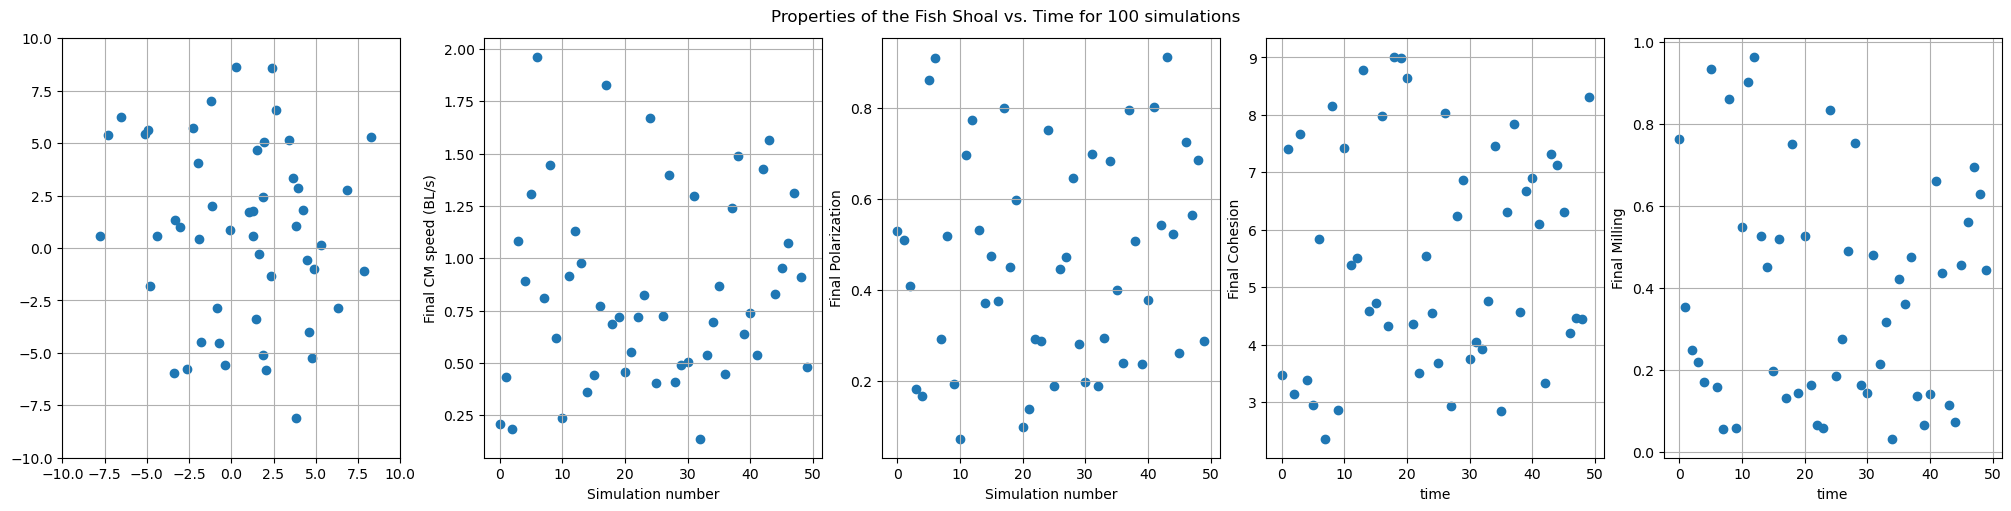

In [ ]:
#plot each for N = 5

# numiterations = 1000
# poolrange = 40 #poolrange/2 is the length of each side
# initcoordmax = 20 #essentially initial density
# numfish = 5
# inittime = 0

# totalcmarray = []
# totalcmVarray = []
# totalParray = []
# totalCarray = []
# totalMarray = []

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for 100 simulations')

Nsim = np.arange(numsim)

#plot center of masses
cmxcoords, cmycoords = zip(*totalcmarray)

axs[0].scatter(cmxcoords, cmycoords)
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()

#plot center of mass speeds
cmspeed = [np.linalg.norm(velocity) for velocity in totalcmVarray]

axs[1].scatter(Nsim, cmspeed)
axs[1].grid()
axs[1].set_xlabel('Simulation number')
axs[1].set_ylabel('Final CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].scatter(Nsim, totalParray)
print(np.mean(totalParray))
axs[2].grid()
axs[2].set_xlabel('Simulation number')
axs[2].set_ylabel('Final Polarization')

# Carray = []
axs[3].scatter(Nsim, totalCarray)
print(np.mean(totalCarray))
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Final Cohesion')

# Marray = []
axs[4].scatter(Nsim, totalMarray)
print(np.mean(totalMarray))
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Final Milling')

plt.show()

Polarization around 0.5, Cohesion around 5, Milling around 0.35

### N = 10

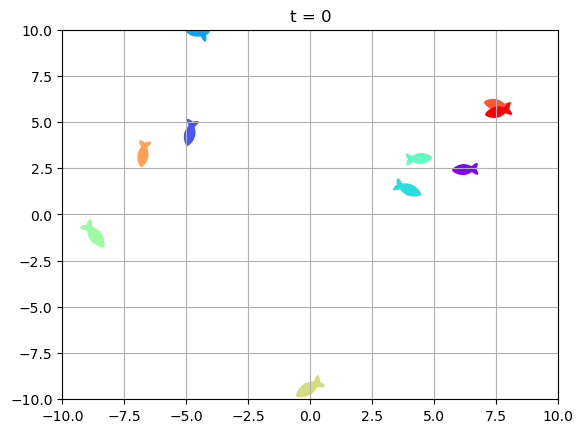

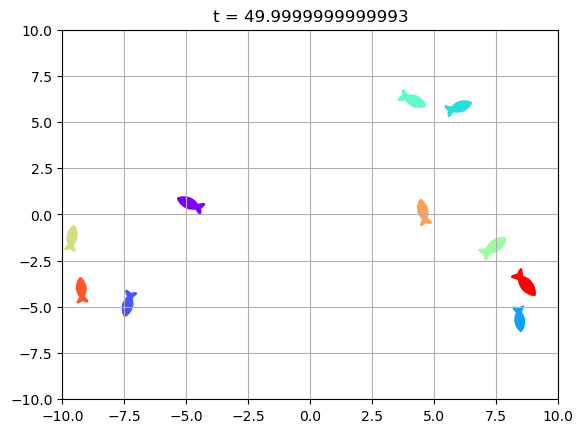

In [ ]:
# N = 10
numiterations = 1000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 10
inittime = 0

#data arrays
positionarray = []
speedarray = []
cmpositionarray = []
cmvelocityarray = []
Parray = []
Carray = []
Marray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
#initial plot
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)

    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

    cmposition = findCM(pos)
    cmpositionarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    cmvelocityarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    Parray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    Carray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    Marray.append(copy.deepcopy(Milling))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')

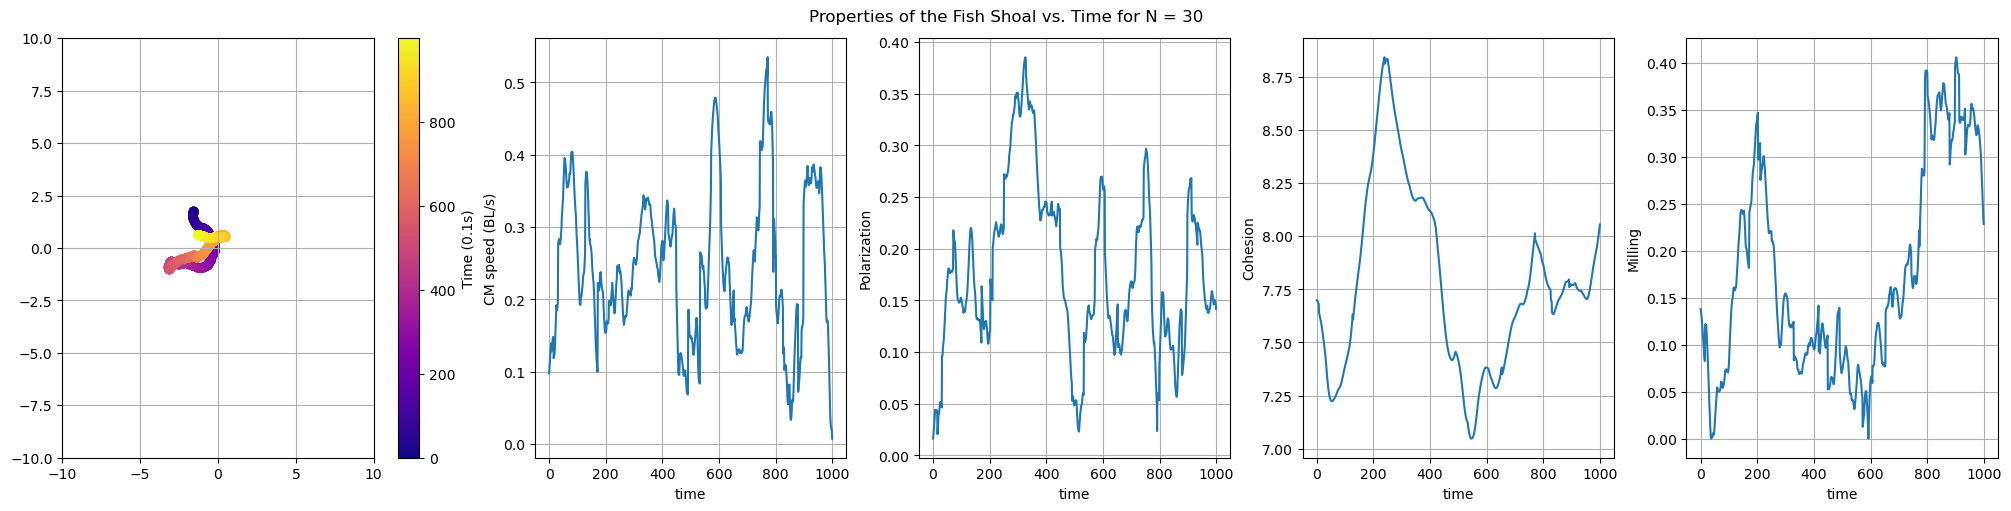

In [ ]:
#N = 10 

# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for N = 10')

time = np.arange(numiterations)

#plot center of mass over time
cmxcoords, cmycoords = zip(*cmpositionarray)
c_values = np.arange(len(cmxcoords))

sc = axs[0].scatter(cmxcoords, cmycoords, c = c_values, cmap = 'plasma')
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label("Time (0.1s)")

#plot center of mass speed over time
cmspeed = [np.linalg.norm(velocity) for velocity in cmvelocityarray]

axs[1].plot(time, cmspeed)
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].plot(time, Parray)
axs[2].grid()
axs[2].set_xlabel('time')
axs[2].set_ylabel('Polarization')

# Carray = []
axs[3].plot(time, Carray)
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Cohesion')

# Marray = []
axs[4].plot(time, Marray)
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Milling')

plt.show()

### N = 30

In [ ]:
#N = 30
numsim = 10

totalcmarray = []
totalcmVarray = []
totalParray = []
totalCarray = []
totalMarray = []

for i in np.arange(numsim):
    numiterations = 2000
    poolrange = 20 #poolrange/2 is the length of each side
    initcoordmax = 10 #essentially initial density
    numfish = 30
    inittime = 0

    pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
    
    #run the simulation numiteration times
    for i in np.arange(numiterations):
        pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, )

    #calculate the final properties
    cmposition = findCM(pos)
    totalcmarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    totalcmVarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    totalParray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    totalCarray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    totalMarray.append(copy.deepcopy(Milling))

Mean Polarization: 0.235427785119043
Mean Cohesion: 7.605987903102277
Mean Milling: 0.12662488325056548


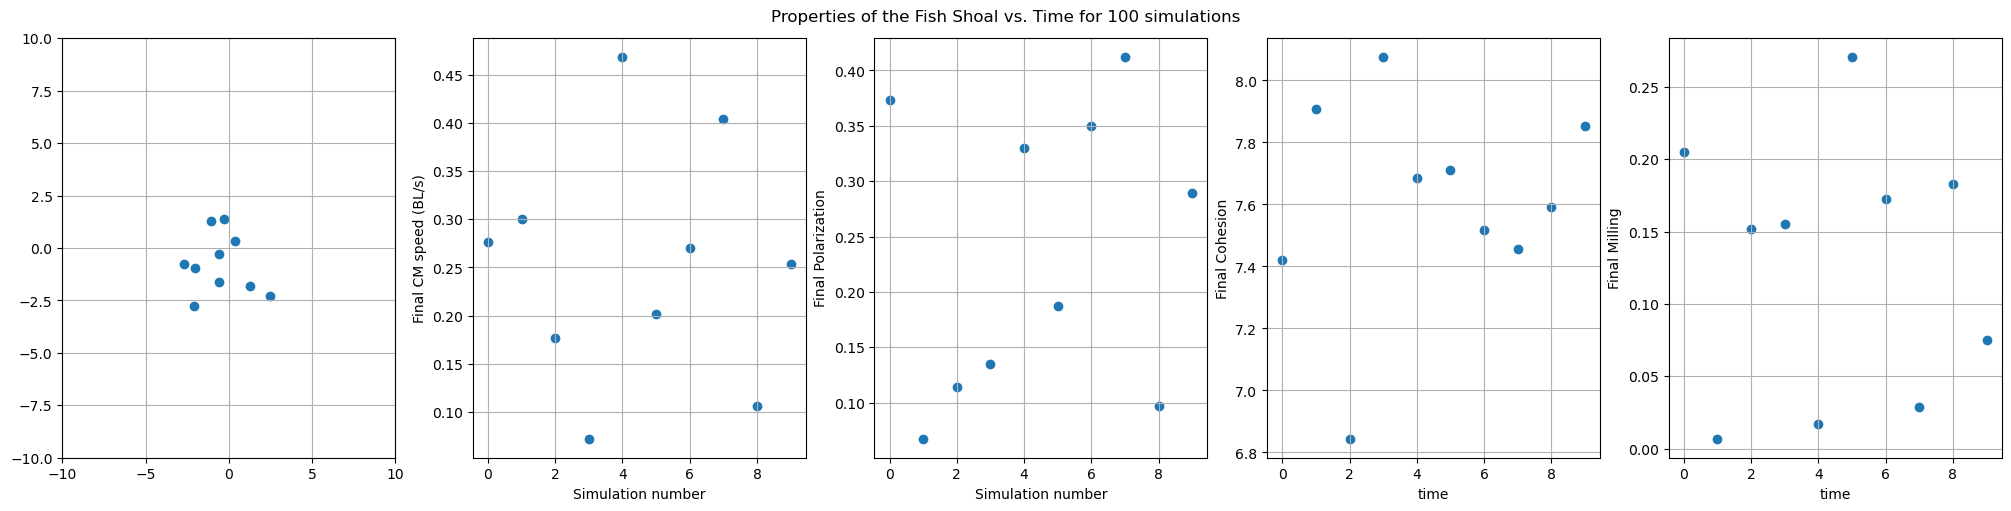

In [214]:
#plot each for N = 30

# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

# totalcmarray = []
# totalcmVarray = []
# totalParray = []
# totalCarray = []
# totalMarray = []

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for 100 simulations')

Nsim = np.arange(len(totalcmarray))

#plot center of masses
cmxcoords, cmycoords = zip(*totalcmarray)

axs[0].scatter(cmxcoords, cmycoords)
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()

#plot center of mass speeds
cmspeed = [np.linalg.norm(velocity) for velocity in totalcmVarray]

axs[1].scatter(Nsim, cmspeed)
axs[1].grid()
axs[1].set_xlabel('Simulation number')
axs[1].set_ylabel('Final CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].scatter(Nsim, totalParray)
print(f'Mean Polarization: {np.mean(totalParray)}')
axs[2].grid()
axs[2].set_xlabel('Simulation number')
axs[2].set_ylabel('Final Polarization')


# Carray = []
axs[3].scatter(Nsim, totalCarray)
print(f'Mean Cohesion: {np.mean(totalCarray)}')
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Final Cohesion')

# Marray = []
axs[4].scatter(Nsim, totalMarray)
print(f'Mean Milling: {np.mean(totalMarray)}')
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Final Milling')

plt.show()

We notice that the average polarization and milling both decrease with N, while cohesion increases. This will be studied in depth later.

# Now we analyze the relation between P,C, and M to various parameters

### P,C,M vs Error in Acceleration

In [ ]:
#Check the P,C,M for various error for N = 5,10,30 to see if anything happens
N = [5,10,30]
Aerrors = np.arange(0,1.1,0.1)

meanParrays = [[],[],[]]
meanCarrays = [[],[],[]]
meanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for A in Aerrors: 
        #Run it many times and find the average properties at t = 1000
        numsim = 20
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, erroracc = A)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        meanParrays[index].append(meanP)
        meanCarrays[index].append(meanC)
        meanMarrays[index].append(meanM)

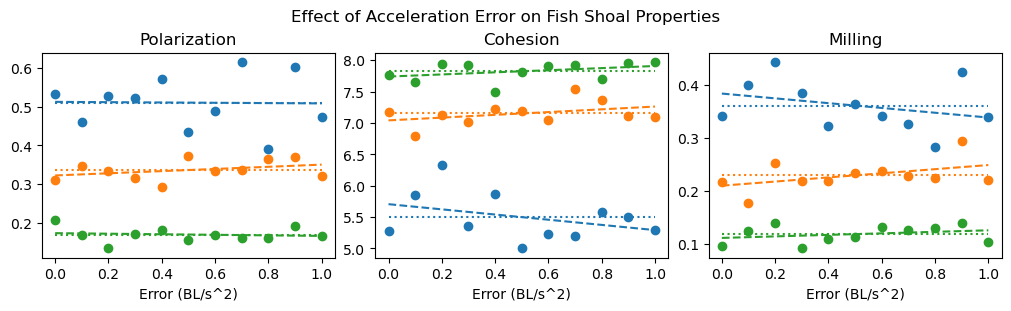

In [354]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Aerrors, meanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(Aerrors,meanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(Aerrors, meanParrays[i], 1)
    line_y = slope * Aerrors + intercept
    
    axs[0].plot(Aerrors, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(meanParrays[0]),np.mean(meanParrays[1]),np.mean(meanParrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Error (BL/s^2)')

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Aerrors, meanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(Aerrors,meanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(Aerrors, meanCarrays[i], 1)
    line_y = slope * Aerrors + intercept
    axs[1].plot(Aerrors, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(meanCarrays[0]),np.mean(meanCarrays[1]),np.mean(meanCarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Error (BL/s^2)')



#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Aerrors, meanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(Aerrors,meanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(Aerrors, meanMarrays[i], 1)
    line_y = slope * Aerrors + intercept
    axs[2].plot(Aerrors, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(meanMarrays[0]),np.mean(meanMarrays[1]),np.mean(meanMarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Error (BL/s^2)')



# color_handles = [
#     plt.Line2D([], [], color=c[i], marker='o', linestyle='None', markersize=8, label=f'N = {N[i]}')
#     for i in range(len(N))
# ]
# fig.legend(handles=color_handles, title='Group Size')
fig.suptitle('Effect of Acceleration Error on Fish Shoal Properties')
plt.savefig('AccelerationError.png')
plt.show()

Conclusion: Average polarization and milling generally increase with N. Further, polarization decreases and milling decreases as acceleration error increases, while N=10 and N=30 show slight but not significant changes in their milling and polarization. 

### P,C,M with Angular Frequency Error

In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
Werrors = np.linspace(0,3,10)

WmeanParrays = [[],[],[]]
WmeanCarrays = [[],[],[]]
WmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for W in Werrors: 
        #Run it many times and find the average properties at t = 1000
        numsim = 20
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, errordw = W)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        WmeanParrays[index].append(meanP)
        WmeanCarrays[index].append(meanC)
        WmeanMarrays[index].append(meanM)

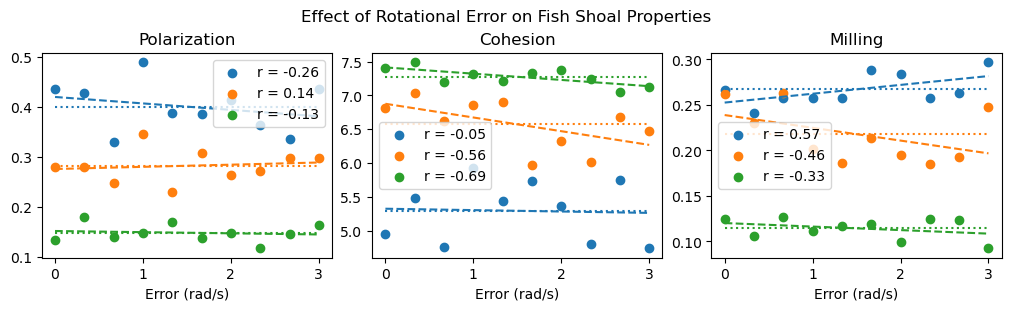

In [ ]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Werrors, WmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(Werrors,WmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(Werrors, WmeanParrays[i], 1)
    line_y = slope * Werrors + intercept
    
    axs[0].plot(Werrors, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(WmeanParrays[0]),np.mean(WmeanParrays[1]),np.mean(WmeanParrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Error (rad/s)')
# axs[0].legend()

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Werrors, WmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(Werrors,WmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(Werrors, WmeanCarrays[i], 1)
    line_y = slope * Werrors + intercept
    axs[1].plot(Werrors, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(WmeanCarrays[0]),np.mean(WmeanCarrays[1]),np.mean(WmeanCarrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Error (rad/s)')
# axs[1].legend()


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(Werrors, WmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(Werrors,WmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(Werrors, WmeanMarrays[i], 1)
    line_y = slope * Werrors + intercept
    axs[2].plot(Werrors, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(WmeanMarrays[0]),np.mean(WmeanMarrays[1]),np.mean(WmeanMarrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Error (rad/s)')
# axs[2].legend()

fig.suptitle('Effect of Rotational Error on Fish Shoal Properties')
# plt.savefig('RotationError.png')
plt.show()

Observations: no clear relatioship between errors and average P,C,M. Although the milling increases at very small error for N=5, this is likely due to the wall repulsion. Further, the cohesion seems to fluctuate largely for small N as error increases. There might be something between 0.2 and 0.3 that I could check 

### Analyzing the effect of Max A on P,C,M

In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
maxas = np.linspace(0.1,2.0,10)

MaxAmeanParrays = [[],[],[]]
MaxAmeanCarrays = [[],[],[]]
MaxAmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for a in maxas: 
        #Run it many times and find the average properties at t = 1000
        numsim = 10
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, maxa = a)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        MaxAmeanParrays[index].append(meanP)
        MaxAmeanCarrays[index].append(meanC)
        MaxAmeanMarrays[index].append(meanM)

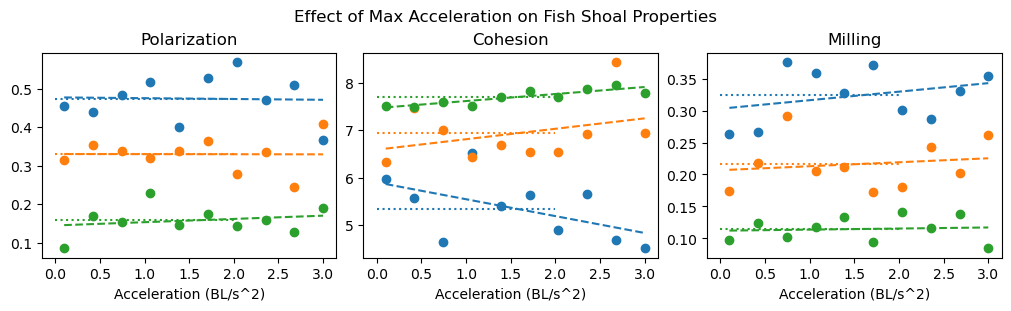

In [667]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxAmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(maxas,MaxAmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(maxas, MaxAmeanParrays[i], 1)
    line_y = slope * maxas + intercept
    
    axs[0].plot(maxas, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(MaxAmeanParrays[0]),np.mean(MaxAmeanParrays[1]),np.mean(MaxAmeanParrays[2])], xmin = 0, xmax = 2.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Acceleration (BL/s^2)')

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxAmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(maxas,MaxAmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(maxas, MaxAmeanCarrays[i], 1)
    line_y = slope * maxas + intercept
    axs[1].plot(maxas, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(MaxAmeanCarrays[0]),np.mean(MaxAmeanCarrays[1]),np.mean(MaxAmeanCarrays[2])], xmin = 0, xmax = 2.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Acceleration (BL/s^2)')


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxAmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(maxas,MaxAmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(maxas, MaxAmeanMarrays[i], 1)
    line_y = slope * maxas + intercept
    axs[2].plot(maxas, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(MaxAmeanMarrays[0]),np.mean(MaxAmeanMarrays[1]),np.mean(MaxAmeanMarrays[2])], xmin = 0, xmax = 2.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Acceleration (BL/s^2)')

fig.suptitle('Effect of Max Acceleration on Fish Shoal Properties')
# plt.savefig('MaxAeffect.png')
plt.show()

Milling may increase with higher max acceleration, but the effect is small for higher Ns. This could be due to the fish bumping into the walls, which causes them to rotate with the wall, increasing their milling. 

### Analyzing the Effect of max w on P,C,M

In [57]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
maxas = np.linspace(0.1,3.0,10)

MaxWmeanParrays = [[],[],[]]
MaxWmeanCarrays = [[],[],[]]
MaxWmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for a in maxas: 
        #Run it many times and find the average properties at t = 1000
        numsim = 20
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, maxa = a)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        MaxWmeanParrays[index].append(meanP)
        MaxWmeanCarrays[index].append(meanC)
        MaxWmeanMarrays[index].append(meanM)

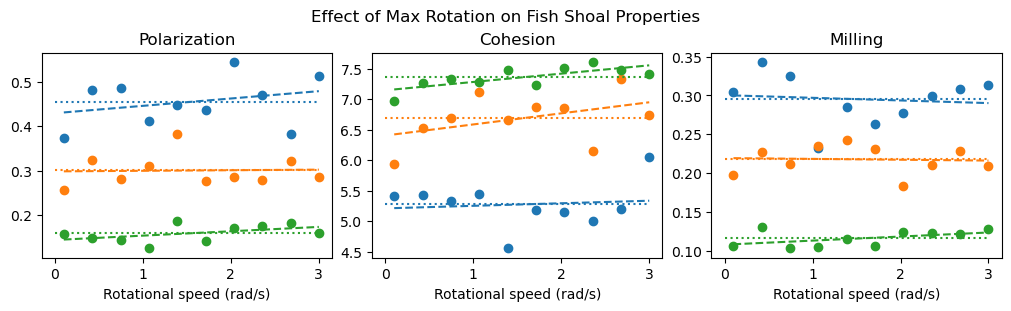

In [58]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxWmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(maxas,MaxWmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(maxas, MaxWmeanParrays[i], 1)
    line_y = slope * maxas + intercept
    
    axs[0].plot(maxas, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(MaxWmeanParrays[0]),np.mean(MaxWmeanParrays[1]),np.mean(MaxWmeanParrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Rotational speed (rad/s)')


#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxWmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(maxas,MaxWmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(maxas, MaxWmeanCarrays[i], 1)
    line_y = slope * maxas + intercept
    axs[1].plot(maxas, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(MaxWmeanCarrays[0]),np.mean(MaxWmeanCarrays[1]),np.mean(MaxWmeanCarrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Rotational speed (rad/s)')


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(maxas, MaxWmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(maxas,MaxWmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(maxas, MaxWmeanMarrays[i], 1)
    line_y = slope * maxas + intercept
    axs[2].plot(maxas, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(MaxWmeanMarrays[0]),np.mean(MaxWmeanMarrays[1]),np.mean(MaxWmeanMarrays[2])], xmin = 0, xmax = 3.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Rotational speed (rad/s)')


fig.suptitle('Effect of Max Rotation on Fish Shoal Properties')
plt.savefig('MaxWeffect.png')
plt.show()

### Analyzing the Effect of Density on P,C,M

In [279]:
#Effect of density/number of fish on P,C,M
N = np.linspace(5,50,10, dtype = int)

DmeanParrays = []
DmeanCarrays = []
DmeanMarrays = []

for index in np.arange(len(N)):
    numsim = 20
    totalParray = []
    totalCarray = []
    totalMarray = []
    
    for n in np.arange(numsim):
        numiterations = 1000
        poolrange = 20 #poolrange/2 is the length of each side
        initcoordmax = 10 #essentially initial density
        numfish = N[index]
        inittime = 0

        pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
        
        #run the simulation numiteration times
        for i in np.arange(numiterations):
            pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)

        Polarization = findP(motorientations)
        totalParray.append(copy.deepcopy(Polarization))

        Cohesion = findCohesion(pos)
        totalCarray.append(copy.deepcopy(Cohesion))

        Milling = findMilling(pos, motorientations)
        totalMarray.append(copy.deepcopy(Milling))

    DmeanParrays.append(totalParray)
    DmeanCarrays.append(totalCarray)
    DmeanMarrays.append(totalMarray)

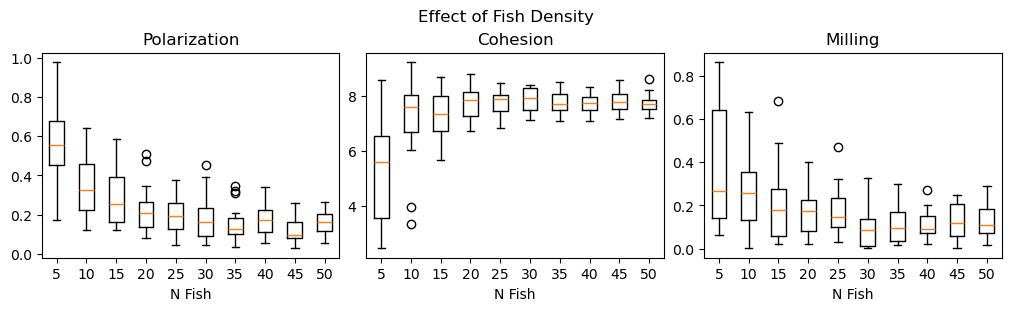

In [ ]:
#plot the P,C,M vs number of fish/density
N = np.linspace(5,50,10, dtype = int)
# densities = N/poolrange**2
fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

#polarization plot
axs[0].boxplot(DmeanParrays)
axs[0].set_title('Polarization')
axs[0].set_xticks(ticks=np.arange(1, len(N) + 1), labels=N)
axs[0].set_xlabel('N Fish')

#cohesion plot
axs[1].boxplot(DmeanCarrays)
axs[1].set_title('Cohesion')
axs[1].set_xticks(ticks=np.arange(1, len(N) + 1), labels=N)
axs[1].set_xlabel('N Fish')

#Milling plot
axs[2].boxplot(DmeanMarrays)
axs[2].set_title('Milling')
axs[2].set_xticks(ticks=np.arange(1, len(N) + 1), labels=N)
axs[2].set_xlabel('N Fish')

fig.suptitle('Effect of Fish Density')
plt.savefig('Fishdensityeffect.pdf')
plt.show()


We see again that polarization and milling both decrease with N, while cohesion increases (meaning, the fish become more spread out).

### Analyzing the Effect of Forward Alignment and Acceleration Bias

In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
#W and Abias, front has more pulling effect 0 means only consider front alignment, 1 means consider both equally
biases = np.arange(0.0,1.1,0.1)

BmeanParrays = [[],[],[]]
BmeanCarrays = [[],[],[]]
BmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for a in biases: 
        #Run it many times and find the average properties at t = 1000
        numsim = 20
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, Abias = a, Wbias = a)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        BmeanParrays[index].append(meanP)
        BmeanCarrays[index].append(meanC)
        BmeanMarrays[index].append(meanM)

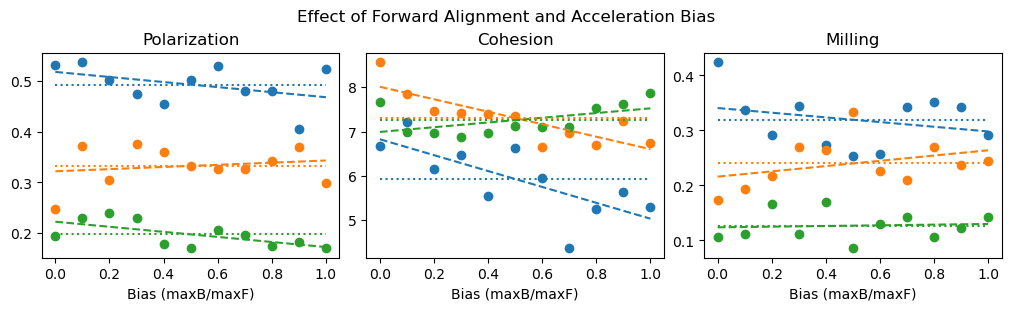

In [291]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(biases,BmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(biases, BmeanParrays[i], 1)
    line_y = slope * biases + intercept
    
    axs[0].plot(biases, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(BmeanParrays[0]),np.mean(BmeanParrays[1]),np.mean(BmeanParrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Bias (maxB/maxF)')

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(biases,BmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BmeanCarrays[i], 1)
    line_y = slope * biases + intercept
    axs[1].plot(biases, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(BmeanCarrays[0]),np.mean(BmeanCarrays[1]),np.mean(BmeanCarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Bias (maxB/maxF)')


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(biases,BmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BmeanMarrays[i], 1)
    line_y = slope * biases + intercept
    axs[2].plot(biases, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(BmeanMarrays[0]),np.mean(BmeanMarrays[1]),np.mean(BmeanMarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Bias (maxB/maxF)')

fig.suptitle('Effect of Forward Alignment and Acceleration Bias')
# plt.savefig('Frontbiaseffect.png')
plt.show()

The anonmaly here is N=30, which is much lower than it should be. This is likely due to wall repulsion and rapid deceleration which causees the fish to become stationary. 

### Analyze the Effect of Acceleration Bias

In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
#Acceleration bias only. front has more pulling effect 0 means only consider front alignment, 1 means consider both equally
biases = np.arange(0.0,1.1,0.1)

BAmeanParrays = [[],[],[]]
BAmeanCarrays = [[],[],[]]
BAmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for a in biases: 
        #Run it many times and find the average properties at t = 1000
        numsim = 30
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, Abias = a)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        BAmeanParrays[index].append(meanP)
        BAmeanCarrays[index].append(meanC)
        BAmeanMarrays[index].append(meanM)

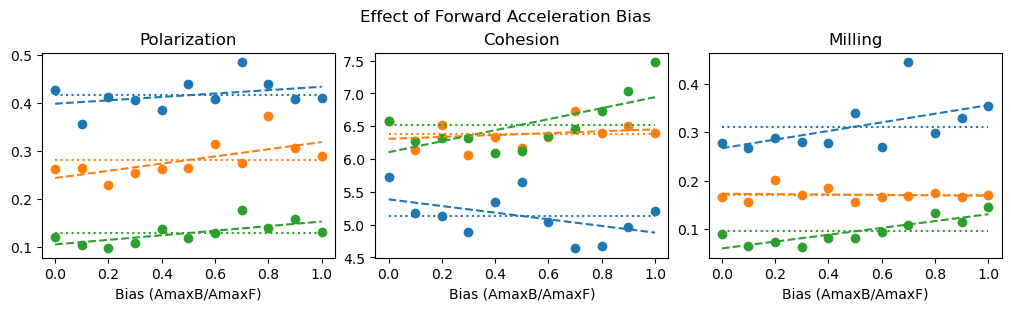

In [419]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BAmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(biases,BAmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(biases, BAmeanParrays[i], 1)
    line_y = slope * biases + intercept
    
    axs[0].plot(biases, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(BAmeanParrays[0]),np.mean(BAmeanParrays[1]),np.mean(BAmeanParrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Bias (AmaxB/AmaxF)')

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BAmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(biases,BAmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BAmeanCarrays[i], 1)
    line_y = slope * biases + intercept
    axs[1].plot(biases, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(BAmeanCarrays[0]),np.mean(BAmeanCarrays[1]),np.mean(BAmeanCarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Bias (AmaxB/AmaxF)')


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BAmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(biases,BAmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BAmeanMarrays[i], 1)
    line_y = slope * biases + intercept
    axs[2].plot(biases, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(BAmeanMarrays[0]),np.mean(BAmeanMarrays[1]),np.mean(BAmeanMarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Bias (AmaxB/AmaxF)')

fig.suptitle('Effect of Forward Acceleration Bias')
plt.savefig('Frontaccelerationbiaseffect.png')
plt.show()

### Effect of Forward Rotational Alignment Bias


In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
#Acceleration bias only. front has more pulling effect 0 means only consider front alignment, 1 means consider both equally
biases = np.arange(0.0,1.1,0.1)

BRmeanParrays = [[],[],[]]
BRmeanCarrays = [[],[],[]]
BRmeanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for a in biases: 
        #Run it many times and find the average properties at t = 1000
        numsim = 30
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, Wbias = a)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        BRmeanParrays[index].append(meanP)
        BRmeanCarrays[index].append(meanC)
        BRmeanMarrays[index].append(meanM)

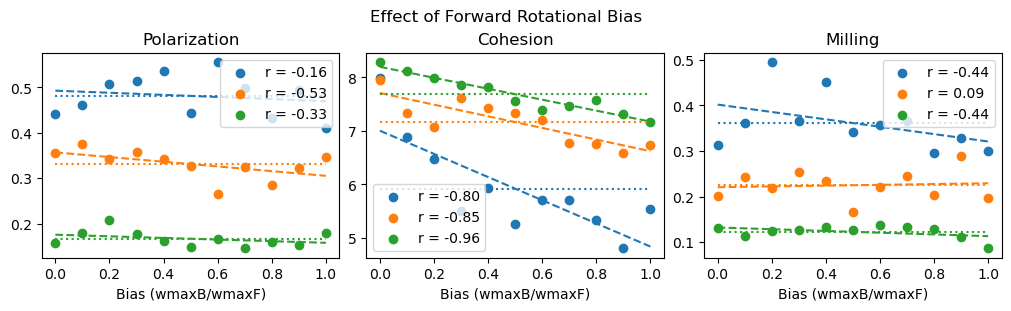

In [666]:
#polarization plot
c = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1,3, constrained_layout = True, figsize  = (10,3))

for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BRmeanParrays[i])
    rvalue = correlation[0,1]

    axs[0].scatter(biases,BRmeanParrays[i], label = f'r = {rvalue:.2f}')

    slope, intercept = np.polyfit(biases, BRmeanParrays[i], 1)
    line_y = slope * biases + intercept
    
    axs[0].plot(biases, line_y, color = c[i], ls = '--')

axs[0].hlines(y = [np.mean(BRmeanParrays[0]),np.mean(BRmeanParrays[1]),np.mean(BRmeanParrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[0].set_title('Polarization')
axs[0].set_xlabel('Bias (wmaxB/wmaxF)')
axs[0].legend()

#cohesion plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BRmeanCarrays[i])
    rvalue = correlation[0,1]

    axs[1].scatter(biases,BRmeanCarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BRmeanCarrays[i], 1)
    line_y = slope * biases + intercept
    axs[1].plot(biases, line_y, color = c[i], ls = '--')

axs[1].hlines(y = [np.mean(BRmeanCarrays[0]),np.mean(BRmeanCarrays[1]),np.mean(BRmeanCarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[1].set_title('Cohesion')
axs[1].set_xlabel('Bias (wmaxB/wmaxF)')
axs[1].legend()


#Milling plot
for i in np.arange(len(N)):
    #calculate the correlation
    correlation = np.corrcoef(biases, BRmeanMarrays[i])
    rvalue = correlation[0,1]

    axs[2].scatter(biases,BRmeanMarrays[i], label = f'r = {rvalue:.2f}')
    slope, intercept = np.polyfit(biases, BRmeanMarrays[i], 1)
    line_y = slope * biases + intercept
    axs[2].plot(biases, line_y, color = c[i], ls = '--')

axs[2].hlines(y = [np.mean(BRmeanMarrays[0]),np.mean(BRmeanMarrays[1]),np.mean(BRmeanMarrays[2])], xmin = 0, xmax = 1.0,  linestyles=':', colors = ['C0', 'C1', 'C2'])
axs[2].set_title('Milling')
axs[2].set_xlabel('Bias (wmaxB/wmaxF)')
axs[2].legend()

fig.suptitle('Effect of Forward Rotational Bias')
plt.savefig('FrontRotationbiaseffect.png')
plt.show()

### Simulate a phase transition by changing the bias midway through the iterations

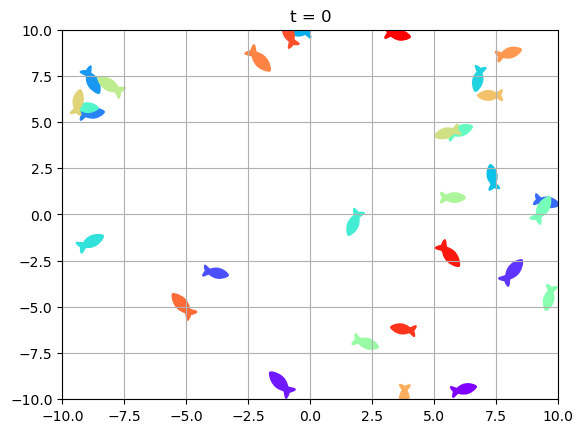

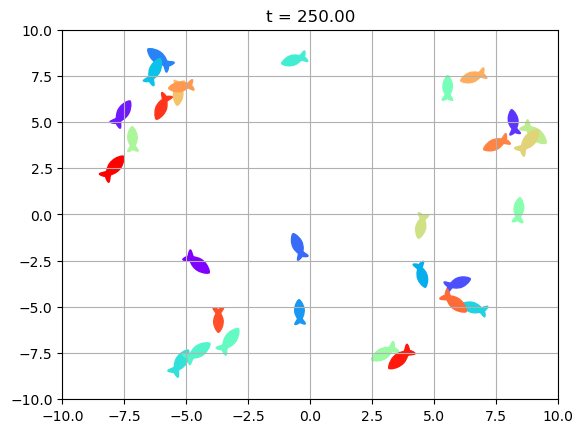

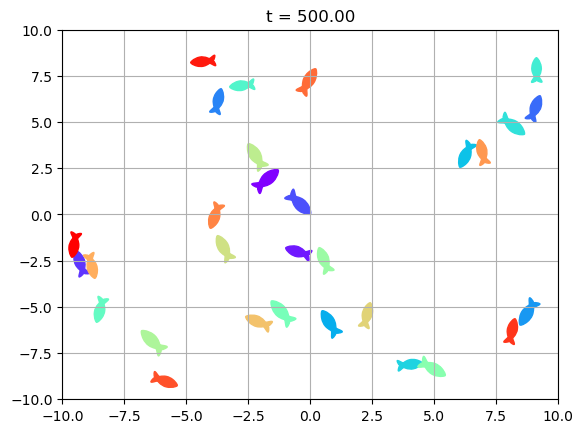

In [ ]:
numiterations = 10000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 30
inittime = 0

#data arrays
positionarray = []
speedarray = []
cmpositionarray = []
cmvelocityarray = []
Parray = []
Carray = []
Marray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
#initial plot
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    bias = 0.5 if i > numiterations/2 else 1
    
    if i == numiterations/2:
        plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime:.2f}')

    pos, motorientations, motspeeds, motvelocity, inittime, dist = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, Wbias = bias)

    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

    cmposition = findCM(pos)
    cmpositionarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    cmvelocityarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    Parray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    Carray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    Marray.append(copy.deepcopy(Milling))


plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime:.2f}')

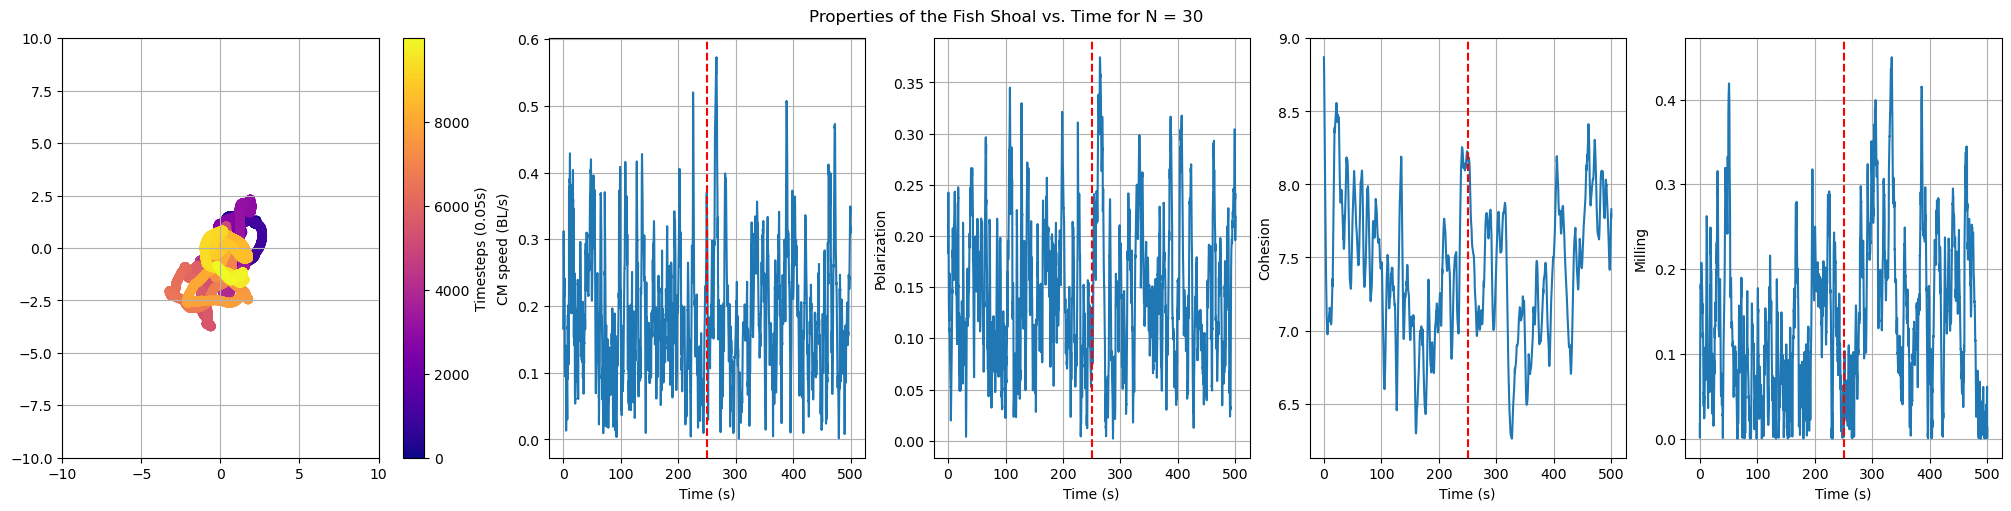

In [643]:
#N = 10 

# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle(f'Properties of the Fish Shoal vs. Time for N = {numfish}')

time = np.arange(numiterations)
vline = numiterations*0.5*0.05
timescaled = time*0.05

#plot center of mass over time
cmxcoords, cmycoords = zip(*cmpositionarray)
c_values = np.arange(len(cmxcoords))

sc = axs[0].scatter(cmxcoords, cmycoords, c = c_values, cmap = 'plasma')
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label("Timesteps (0.05s)")

#plot center of mass speed over time
cmspeed = [np.linalg.norm(velocity) for velocity in cmvelocityarray]

axs[1].plot(timescaled, cmspeed)
axs[1].grid()
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('CM speed (BL/s)')
axs[1].axvline(x=vline, color='r', linestyle='--')

# plot polarization over time Parray = []
axs[2].plot(timescaled, Parray)
axs[2].grid()
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Polarization')
axs[2].axvline(x=vline, color='r', linestyle='--')

# Carray = []
axs[3].plot(timescaled, Carray)
axs[3].grid()
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Cohesion')
axs[3].axvline(x=vline, color='r', linestyle='--')

# Marray = []
axs[4].plot(timescaled, Marray)
axs[4].grid()
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Milling')
axs[4].axvline(x=vline, color='r', linestyle='--')

plt.show()

In [54]:
slice = int(numiterations/2)

Pbefore = np.mean(Parray[:slice])
Pafter = np.mean(Parray[slice:])
print(f'Change in P {Pafter-Pbefore}')

Cbefore = np.mean(Carray[:slice])
Cafter = np.mean(Carray[slice:])
print(f'Change in C {Cafter-Cbefore}')

Mbefore = np.mean(Marray[:slice])
Mafter = np.mean(Marray[slice:])
print(f'Change in M {Mafter-Mbefore}')


Change in P -0.004628656313727331
Change in C 0.07428153912543412
Change in M -0.012227753210889314


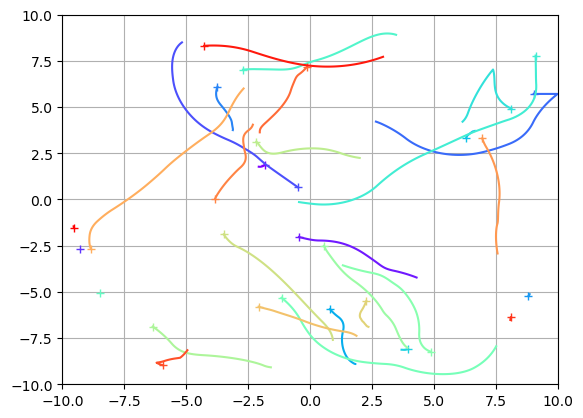

In [645]:
#trajectory plot
fig, ax = plt.subplots()

plotmaxcoord = poolrange/2
trajlength = 100

colors = cm.rainbow(np.linspace(0, 1, numfish))

for n in np.arange(numfish):
    coordinates = []
    for i in np.arange(numiterations):
        coordinates.append(positionarray[i][n])
    fishcoordsx, fishcoordsy = zip(*coordinates)

    recent_x = fishcoordsx[-trajlength:]
    recent_y = fishcoordsy[-trajlength:] 

    ax.plot(recent_x, recent_y, color=colors[n])
    ax.plot(recent_x[-1], recent_y[-1], marker='+', color=colors[n])

ax.set_xlim(-plotmaxcoord,plotmaxcoord)
ax.set_ylim(-plotmaxcoord,plotmaxcoord)
ax.grid()
# plt.savefig('traj.png')
plt.show()


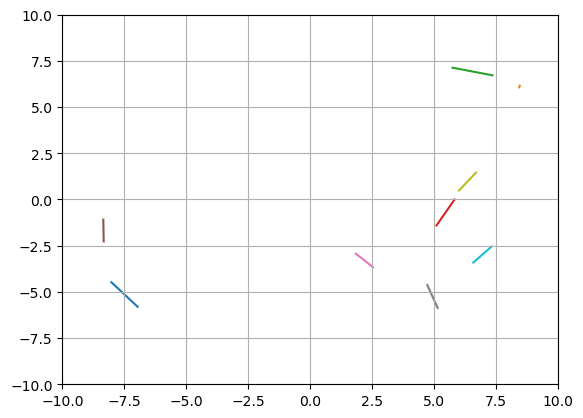

In [594]:
#final velocity plot
plotvel(pos, motorientations, motspeeds, viewrange = (-plotmaxcoord,plotmaxcoord))